# Classification of Moving Clusters

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as img
import scipy.signal as signal 
import scipy.stats as stat
from scipy.signal import fftconvolve
import matplotlib.patches as patch
from functools import partial
from astropy.stats import kuiper
import piecewise_regression

In [2]:
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))
sys.path.append(parent_dir)
from Functions.Detection_functions import MCDA, circular_mask, preprocessing

## Introduction

The purpose of this notebook is to implement a classifier of moving clusters between stationary pulses, target waves, planar waves and complex waves. To do so, two tests are deigned to assess if a given moving cluster is spreading or not, and if it is static or not. Then, two speeds are calculated, the radial speed if the pattern is expanding, and the translational speed if the pattern is moving. Finally, the isotropy of the global movement is tested to track preferential direction of propagation.

$$
\begin{array}{|c|c|c|}
\hline
\textbf{} & \textbf{Static} & \textbf{Moving} \\
\hline
\textbf{Stable} & \text{Stationary pulse} & \text{Planar wave} \\
\hline
\textbf{Spreading} & \text{Target wave} & \text{Complex wave} \\
\hline
\end{array}
$$

### Choice of the dataset

In [3]:
condition='anesthesia' #between anesthesia and awake
session='spontaneous' #between evokedU, evokedD and spontaneous

Write your data directory

In [4]:
original_data_directory=r'C:/Users/mmill/Documents/STAGE M1/DATA/'

Data loading

In [5]:
if condition=='awake':
    if session=='evoked':
        bks_evoked_path = original_data_directory+'gaussian_pos4_ziggy_210908.npy'
        Data = np.load(bks_evoked_path)
    elif session=='spontaneous':
        bks_blank_path = original_data_directory+'blank_ziggy_210908.npy'
        Data = np.load(bks_blank_path)
    mean = np.nanmean(Data)
    nan_loc = np.isnan(Data)
    Data[nan_loc] = mean
    N_trials, Nt, Nx, Ny = Data.shape
    fs = 100 #Hz
    pixel_spacing = 0.045 #mm
    line=np.array([[ 49, 409],[ 87, 131]])
    circle =[[219, 187], 199]

if condition=='anesthesia':
    if session=='evokedD':
        anesth_evokedD_path = original_data_directory+'signal_240306_gaussianD.mat'
        file_anesth_evokedD = h5py.File(anesth_evokedD_path)['signal']
        Data = np.rot90(np.array(file_anesth_evokedD),2, axes=(2,3))
    elif session=='evokedU':
        anesth_evokedU_path = original_data_directory+'signal_240306_gaussianU.mat'
        file_anesth_evokedU = h5py.File(anesth_evokedU_path)['signal']
        Data = np.rot90(np.array(file_anesth_evokedU),2, axes=(2,3))
    elif session=='spontaneous':
        anesth_blank_path = original_data_directory+'signal_240306_blank.mat' #change it to adapt to your directories
        file_anesth_blank = h5py.File(anesth_blank_path)['signal']
        Data = np.rot90(np.array(file_anesth_blank), 2,axes=(2,3))
    N_trials, Nt, Nx, Ny = Data.shape
    fs=110 #Hz
    pixel_spacing = 0.064 #mm
    line=np.array([[251,   5],[ 90, 118]])
    circle=[[145, 125], 140]
mask = circular_mask((Nx,Ny), center=circle[0], radius=circle[1])

Definition of the parameters for Moving Clusters Detection Algorithm (MCDA)

In [6]:
eps=15
MinPts=32
theta=.40
minimal_dist=10
sign_level=0.05

### Choice of the trial

In [65]:
trial_number=3
test_trial=Data[trial_number]
preprocessed_trial = preprocessing(trial=test_trial, border_mask=mask, fs=fs, fc=30, threshold=99)

Run MCDA

In [66]:
moving_clusters = MCDA(Trial=preprocessed_trial, Epsilon=eps, MinPts=MinPts, Theta=theta)
print(f'{len(moving_clusters)} MC detected')

2 MC detected


Look at the detected Moving Clusters (MC)

In [67]:
for i,mc in enumerate(moving_clusters):
    print(f'Pattern n°{i}, Trace={mc['trace']}, length={len(mc['trace'])}')

Pattern n°0, Trace=[110, 111, 112, 113, 114, 115, 116], length=7
Pattern n°1, Trace=[124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136], length=13


### Choice of the MC index

In [123]:
mc_ind=1
ncol=5

## 1: Points of a detected moving cluster and lists of coordinates (X,Y,T)

In [124]:
pts=moving_clusters[mc_ind]['points']
pts_stack = np.concatenate(pts)
Trace=np.array(moving_clusters[mc_ind]['trace'])
T=[time for index,time in enumerate(Trace) for _ in range(len(pts[index]))]
X,Y = pts_stack[:, 0], pts_stack[:, 1]

### Visualisation of the moving cluster

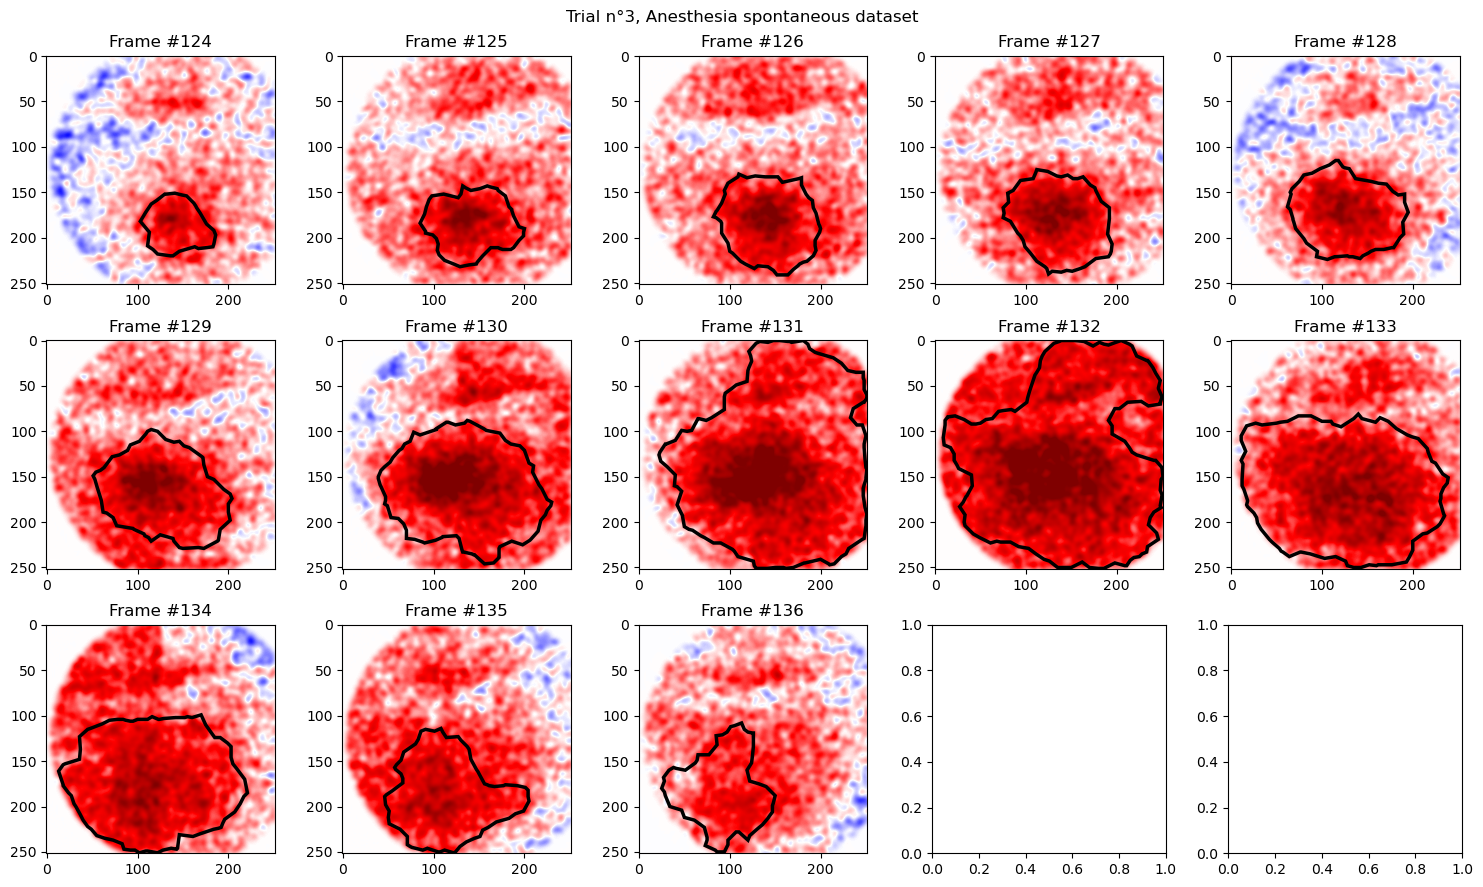

In [125]:
nrow=len(pts)//ncol+(len(pts)%ncol>0)
Norm = colors.Normalize(vmax=1, vmin=-1)
fig, axs = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*3),layout='tight')
fig.suptitle(f'Trial n°{trial_number}, {condition.capitalize()} {session} dataset')
for index,frame_number in enumerate(Trace):
    axs[index//ncol, index%ncol].set_title(f'Frame #{frame_number}')
    axs[index//ncol, index%ncol].imshow(img.gaussian_filter(test_trial[frame_number]*mask, sigma=3, mode='constant'), cmap='seismic', norm=Norm)
    x, y = moving_clusters[mc_ind]['alpha shapes'][index].exterior.xy
    mpl_poly = patch.Polygon(list(zip(y,x)), closed=True, edgecolor='k', facecolor='none', linewidth=2.5)
    axs[index//ncol, index%ncol].add_patch(mpl_poly)
plt.show()

## 2: Translation test

### 2.A: Linear correlation between spatial coordinates and time?

Draw the linear regression

In [126]:
resx = stat.linregress(T,X)
resx

LinregressResult(slope=-1.0318627682532737, intercept=295.33634012146155, rvalue=-0.05985251808834703, pvalue=4.946919635141961e-14, stderr=0.13684828535340943, intercept_stderr=17.942996295015245)

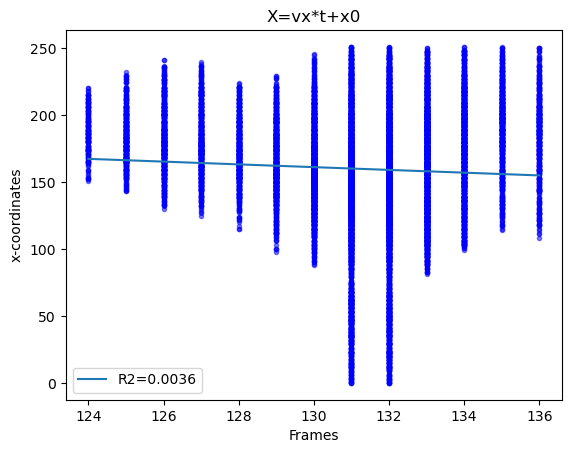

In [127]:
plt.figure()
plt.title('X=vx*t+x0')
plt.plot(T,X,'b.', alpha=.5)
plt.plot(T, [resx.intercept+resx.slope*time for time in T], label=f'R2={np.round(resx.rvalue**2,4)}')
plt.xlabel('Frames')
plt.ylabel('x-coordinates')
plt.legend()

In [128]:
resy = stat.linregress(T,Y)
resy

LinregressResult(slope=-2.523372514737666, intercept=462.79951222770126, rvalue=-0.1441640237237959, pvalue=3.3201216428137605e-74, stderr=0.13773458954491266, intercept_stderr=18.05920493280219)

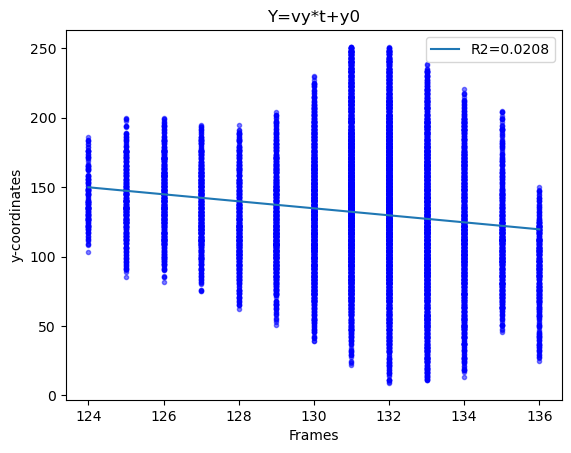

In [129]:
plt.figure()
plt.title('Y=vy*t+y0')
plt.plot(T,Y,'b.', alpha=.5)
plt.plot(T, [resy.intercept+resy.slope*time for time in T], label=f'R2={np.round(resy.rvalue**2,4)}')
plt.xlabel('Frames')
plt.ylabel('y-coordinates')
plt.legend()

resulting speed and angle

In [130]:
np.linalg.norm((resx.slope, resy.slope))*pixel_spacing/1000*fs

0.01919242628325953

In [131]:
np.arctan2(resy.slope,resx.slope)

-1.9589704216320427

Not appropriate, check new section

### 2.B: Trajectory of the centroid

In [132]:
Centers=np.array([np.mean(clust_pts,axis=0) for clust_pts in moving_clusters[mc_ind]['points']])

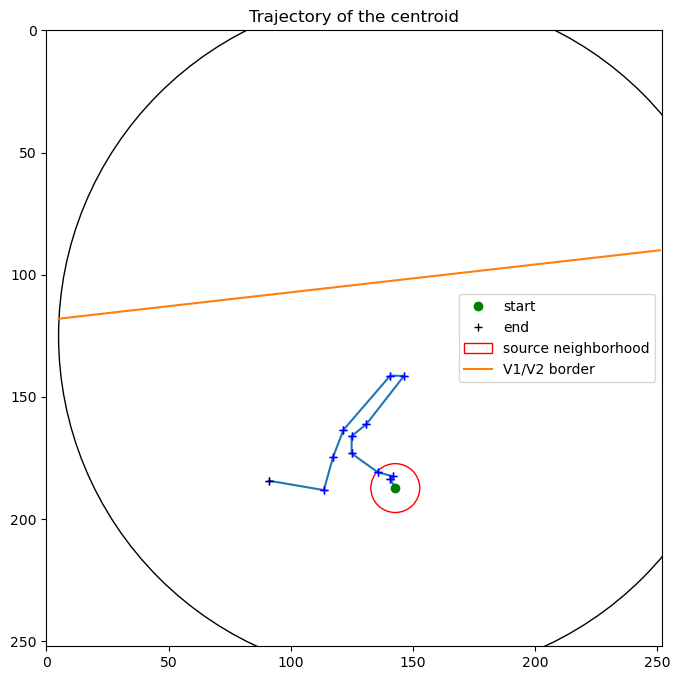

In [133]:
fig, ax = plt.subplots(figsize=(16,8))
ax.set_title('Trajectory of the centroid')
ax.plot(Centers[:,1], Centers[:,0])
ax.set_aspect('equal')
ax.add_patch(patch.Circle(circle[0], circle[1], color='k',fill=False))
ax.plot(Centers[:,1], Centers[:,0], 'b+')
ax.plot(Centers[1:-1,1], Centers[1:-1,0], 'b+')
ax.plot(Centers[0,1], Centers[0,0], 'go', label='start')
ax.plot(Centers[-1,1], Centers[-1,0], 'k+', label='end')
ax.add_patch(patch.Circle(Centers[0][::-1], minimal_dist, color='r', fill=False, label='source neighborhood'))
ax.plot(line[0],line[1], label='V1/V2 border')
ax.set_xlim(0,Ny)
ax.set_ylim(0,Nx)
ax.invert_yaxis()
ax.legend()

### 2.C: Directional Persistance parameter

Let $DP$ be the $\textbf{directional persistence parameter}$, which quantifies the degree to which a system maintains its direction of motion over time. It is defined as follows:
$$
DA =\frac{1}{T} \int_0^T \frac{\langle \mathbf{v}(t) | \mathbf{v}(t + dt) \rangle}{ \|\mathbf{v}(t)\| \cdot \|\mathbf{v}(t + dt)\|} dt
$$

or simply 
$$
DA = \frac{1}{N-1} \sum_{i=1}^{N-1} \frac{\langle \mathbf{v}_{i} \space | \space \mathbf{v}_{i + 1} \rangle}{ \|\mathbf{v}_i \space \|  \cdot \|\mathbf{v}_{i+1}\|} \in [-1,1]
$$

where $\mathbf{v}(t)$ is the velocity vector at time $t$ and $\langle \cdot | \cdot  \rangle $ denotes the dot product


The parameter $DP$ ranges from $-1$ to $1$:

$DP = 1$ indicates perfect directional persistence (straight line).

$DP = 0$ indicates no directional persistence (random motion).

$DP = -1$ indicates complete directional reversal (alternating between two points).

In [134]:
# Compute instantaneous velocities
velocities = np.diff(Centers, axis=0)

# Compute the dot products and norms
dot_products = np.einsum('ij,ij->i', velocities[:-1], velocities[1:])
norms = np.linalg.norm(velocities, axis=1)
norms_product = norms[:-1]*norms[1:]

# Compute directional persistence
DPP = np.mean(dot_products / norms_product)

print(f"Directional Persistence: {DPP}")

# Interpretation
if DPP > 0.5:
    print("The cluster exhibits strong directional movement.")
elif DPP < 0:
    print("The cluster exhibits anti-persistent movement.")
else:
    print("The cluster exhibits random or weak directional movement.")

Directional Persistence: 0.43797409198209797
The cluster exhibits random or weak directional movement.


In [135]:
dot_products / norms_product

array([ 0.2001248 , -0.57750654,  0.93032675,  0.58246433,  0.62993056,
        0.97416647, -0.59030586,  0.62913429,  0.94104247,  0.99559967,
        0.10273808])

In [136]:
def compute_sample_mean_pdf(N, pdf, x_range):
    # Generate the pdf of the original distribution
    x = np.linspace(x_range[0], x_range[1], 100000)
    pdf_x = [pdf(y) for y in x]
    
    # Compute the convolution of the pdf with itself N times
    pdf_sum = pdf_x
    for _ in range(N - 2):
        pdf_sum = fftconvolve(pdf_sum, pdf_x, mode='same')
        pdf_sum /= np.trapz(pdf_sum, x)  # Normalize the pdf after convolution
    
    # Scale the pdf to get the pdf of the sample mean
    pdf_sample_mean = (N-1)* pdf_sum
    scaled_x = x / (N-1)

    return scaled_x, pdf_sample_mean

In [137]:
N = len(pts)
x_range = (-N, N)  # Adjust the range as necessary

def PDF(y):
    # Probability density function of X = cos(Theta)
    if abs(y)<1:
        return 1/(np.pi*np.sqrt(1 - y**2))
    else:
        return 0

scaled_x, pdf_sample_mean = compute_sample_mean_pdf(N-1, PDF, x_range)

In [138]:
dx = scaled_x[1]-scaled_x[0]
argu=np.argmin((scaled_x-DPP)**2)
pv=np.sum(pdf_sample_mean[argu:]*dx)
print(f'p-value={pv}')

p-value=0.01895355516426624


In [139]:
np.trapz(pdf_sample_mean[argu:], scaled_x[argu:])

0.01895082335587703

In [140]:
np.sum(pdf_sample_mean*dx)

1.0000000000004654

In [141]:
S=np.cumsum(pdf_sample_mean*dx)
level_index=np.argmin((S+sign_level-1)**2)
print(level_index)

64821


In [142]:
sum(pdf_sample_mean[:level_index]*dx)

0.9499845069821864

Simulations

In [143]:
ang=np.random.uniform(0,2*np.pi, (N-2,10000))
Dpp = np.mean(np.cos(ang),axis=0)

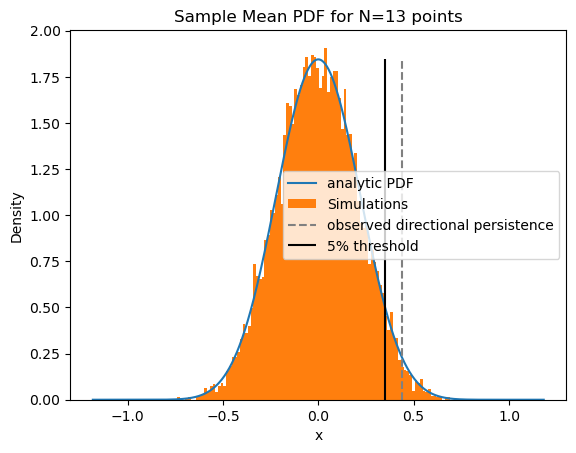

In [144]:
plt.figure()
plt.plot(scaled_x, pdf_sample_mean, label='analytic PDF')
plt.hist(Dpp, density=True, bins=100, label='Simulations')
plt.xlabel('x')
plt.ylabel('Density')
plt.title(f'Sample Mean PDF for N={N} points')
plt.vlines(DPP, 0, max(pdf_sample_mean), label='observed directional persistence', linestyles='dashed', color='gray')
plt.vlines(scaled_x[level_index], 0, max(pdf_sample_mean), label='5% threshold', linestyles='solid', color='k')
plt.legend()
plt.show()

### Conclusion

In [145]:
def pdf_cos_theta(y):
    # Probability density function of X = cos(Theta) if Theta follows a uniform law
    if abs(y)<1:
        return 1/(np.pi*np.sqrt(1 - y**2))
    else:
        return 0

In [146]:
def dp_pdf(N):
    # Probability density function of Y= mean( cos(Theta) ) if Theta follows a uniform law
    x = np.linspace(1-N, N-1, 100000)
    pdf_x = [pdf_cos_theta(y) for y in x]
    pdf_sum = pdf_x
    for _ in range(N-2):    # Compute the convolution of the pdf with itself N-2 times
        pdf_sum = fftconvolve(pdf_sum, pdf_x, mode='same')
        pdf_sum /= np.trapz(pdf_sum, x)  # Normalize the pdf after convolution
    pdf_sample_mean = (N-1)* pdf_sum # Scale the pdf to get the pdf of the sample mean
    scaled_x = x / (N-1)
    return scaled_x, pdf_sample_mean

In [147]:
def translation_test(pts, MinDist, significance_level):
    N=len(pts)
    centroids = [np.mean(points, axis=0) for points in pts]
    source=centroids[0]
    velocities=np.diff(centroids, axis=0)
    dot_products = np.einsum('ij,ij->i', velocities[:-1], velocities[1:])
    norms = np.linalg.norm(velocities, axis=1)
    prod_norms=norms[:-1]*norms[1:]
    directional_persistence = np.mean(dot_products / prod_norms)
    xrange, density_function = dp_pdf(N-1)
    dp_index=np.argmin((xrange-directional_persistence)**2)
    prob=np.trapz(density_function[dp_index:], xrange[dp_index:])
    test_persistence = prob < significance_level
    centroids_from_source = np.linalg.norm(centroids - source, axis=1)
    test_mindist = np.max(centroids_from_source)>MinDist
    inter_test = test_persistence and test_mindist
    return (inter_test, np.append(norms, np.nan) if inter_test else np.full(N,np.nan))

In [148]:
Translation=translation_test(pts, minimal_dist, sign_level)
if Translation[0]:
    print('The detected pattern is moving')
else:
    print('The detected pattern is static')

The detected pattern is moving


## 3: Expansion test

This test aims to assess if the pattern is speading or not. To do so, each is point is analysed in its own frame of reference, i.e. with its centroid as origin. Then, the distance from the center at each moment ("radius" $ \rho $) is calculated. The test is passed if $ \rho $ is increasing with time. The test checks also if the surface of the pattern is increasing to ensure a more robust result. 

### 3.A: Increasing pattern surface?

In [149]:
surfaces=[pixel_spacing**2*shape.area for shape in moving_clusters[mc_ind]['alpha shapes']]
reg_surf=stat.linregress(Trace,surfaces, alternative='greater')
reg_surf

LinregressResult(slope=6.001348923076923, intercept=-708.1182129230768, rvalue=0.45446542574671256, pvalue=0.05935949093706794, stderr=3.5466189241753634, intercept_stderr=461.25139239702503)

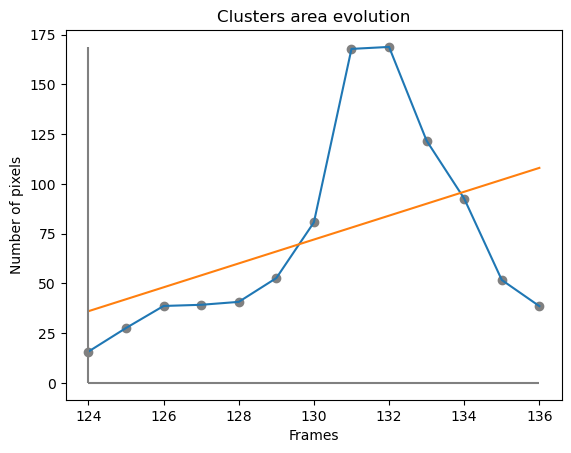

In [150]:
plt.figure()
plt.title('Clusters area evolution')
plt.ylabel('Number of pixels')
plt.xlabel('Frames')
plt.plot(Trace, surfaces)
plt.plot(Trace, reg_surf.intercept+reg_surf.slope*Trace)
plt.scatter(Trace, surfaces,c='gray',marker='o')
plt.hlines(0,Trace[0], Trace[-1], color='gray')
plt.vlines(Trace[0], 0,max(surfaces), color='gray')

In [151]:
res_surf=stat.spearmanr(Trace[:np.argmax(surfaces)+1],surfaces[:np.argmax(surfaces)+1],alternative='greater')
print(f'p-value={res_surf.pvalue}')
if res_surf.pvalue<.05:
    print('Surface test is passed')
else:
    print('Surface test not passed')


p-value=0.0
Surface test is passed


In [152]:
stat.spearmanr(Trace, surfaces, alternative='greater')

SignificanceResult(statistic=0.532967032967033, pvalue=0.03036825153280896)

### 3.B: Is the mean radius discernible? (exceeding a certain minimal distance)

In [153]:
pts_dist_to_centroid=[]
for clust in pts:
    center=np.mean(clust, axis=0) ##centroid location at each moment
    dist=np.linalg.norm(clust-center,axis=1) ## radius calculation
    pts_dist_to_centroid.append(np.mean(dist))
Rho=np.array(pts_dist_to_centroid)

In [154]:
argmx=np.argmax(surfaces)
argmx

8

In [155]:
reg=stat.linregress(Trace,Rho)
reg

LinregressResult(slope=2.313614797585205, intercept=-257.78852544954617, rvalue=0.6318612135518095, pvalue=0.020517849298967765, stderr=0.8556977927145885, intercept_stderr=111.28677954946512)

In [156]:
reg.slope*pixel_spacing/1000*fs

0.01628784817499984

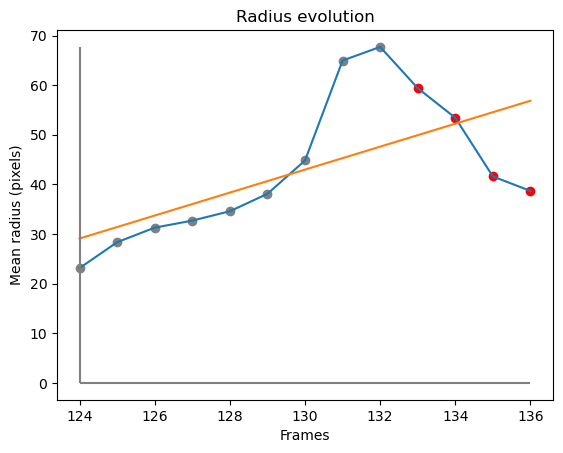

In [157]:
plt.figure()
plt.title('Radius evolution')
plt.plot(Trace,Rho)
plt.plot(Trace, reg.intercept+reg.slope*Trace)
plt.scatter(Trace[:argmx+1],Rho[:argmx+1],c='gray',marker='o')
plt.scatter(Trace[argmx+1:],Rho[argmx+1:],c='red',marker='o')
plt.xlabel('Frames')
plt.ylabel('Mean radius (pixels)')
plt.hlines(0,Trace[0], Trace[-1], color='gray')
plt.vlines(Trace[0], 0,Rho.max(), color='gray')

In [158]:
Rho.max()-Rho.min()

44.562981289999684

In [159]:
Rho.max()-Rho[0]

44.562981289999684

In [160]:
radial_speed = np.diff(Rho)*fs*pixel_spacing/1000
radial_speed.mean()

0.009120328660965989

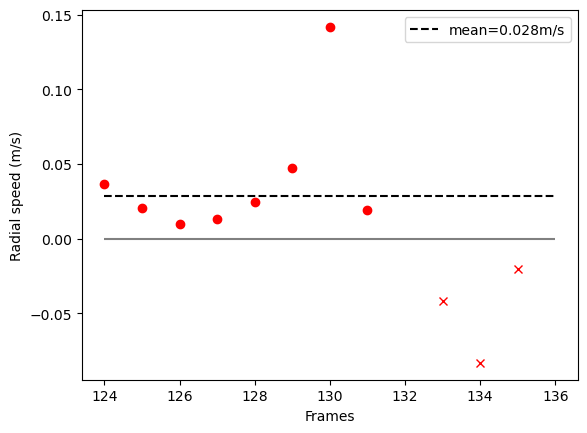

In [161]:
plt.figure()
plt.plot(Trace[:argmx],radial_speed[:argmx],'ro')
plt.plot(Trace[argmx+1:-1],radial_speed[argmx+1:],'rx')
plt.xlabel('Frames')
plt.ylabel('Radial speed (m/s)')
plt.hlines(0,Trace[0], Trace[-1], color='gray')
plt.hlines(radial_speed[:argmx+1].mean(),Trace[0], Trace[-1], color='k', linestyle='--', label=f'mean={np.round(radial_speed[:argmx+1].mean(),3)}m/s')
plt.legend()

In [162]:
res_rho = stat.spearmanr(Trace[:argmx+1],Rho[:argmx+1],alternative='greater')
print(f'p-value={res_rho.pvalue}')
if res_rho.pvalue<.05:
    print('test passed')
else:
    print('test not passed')

p-value=0.0
test passed


In [163]:
stat.spearmanr(Trace,Rho,alternative='greater')

SignificanceResult(statistic=0.7527472527472527, pvalue=0.0014911166945849243)

### 3.C: Piecewise regression

In [164]:
pw_fit = piecewise_regression.Fit(Trace, surfaces, n_breakpoints=1)
pw_fit.summary()


                    Breakpoint Regression Results                     
No. Observations                       13
No. Model Parameters                    4
Degrees of Freedom                      9
Res. Sum of Squares               6121.02
Total Sum of Squares              31737.1
R Squared                        0.807134
Adjusted R Squared               0.710700
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -2341.87     4.31e+02      -5.4331     0.000415      -3316.9      -1366.8
alpha1               18.8446         3.37       5.5972     0.000335       11.228       26.461
beta1               -47.8678         12.1      -3.9433            -      -75.328      -20.407
breakpoint1          132.065        0.735            -            -        130.4       133.73
---------------------

'\n                    Breakpoint Regression Results                     \n====================================================================================================\nNo. Observations                       13\nNo. Model Parameters                    4\nDegrees of Freedom                      9\nRes. Sum of Squares               6121.02\nTotal Sum of Squares              31737.1\nR Squared                        0.807134\nAdjusted R Squared               0.710700\nConverged:                           True\n====================================================================================================\n====================================================================================================\n                    Estimate      Std Err            t        P>|t|       [0.025       0.975]\n----------------------------------------------------------------------------------------------------\nconst               -2341.87     4.31e+02      -5.4331     0.000415      -3316

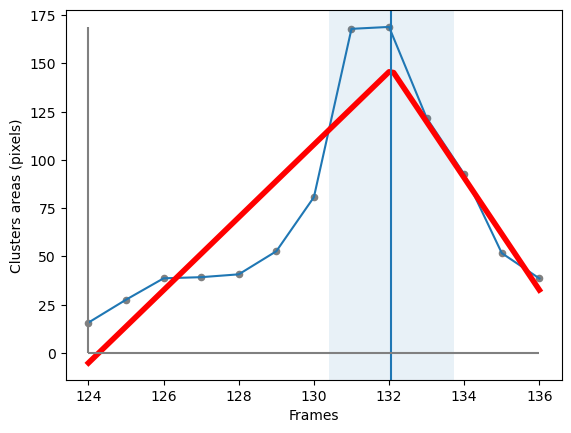

In [165]:
plt.figure()
plt.plot(Trace,surfaces)
pw_fit.plot_data(color="grey", s=20)
# Pass in standard matplotlib keywords to control any of the plots
pw_fit.plot_fit(color="red", linewidth=4)
pw_fit.plot_breakpoints()
pw_fit.plot_breakpoint_confidence_intervals()
plt.xlabel("Frames")
plt.ylabel("Clusters areas (pixels)")
plt.hlines(0,Trace[0], Trace[-1], color='gray')
plt.vlines(Trace[0], 0,max(surfaces), color='gray')
plt.show()


In [166]:
ms=piecewise_regression.ModelSelection(Trace, Rho, max_breakpoints=2)

Running fit with n_breakpoint = 0 . . 
Running fit with n_breakpoint = 1 . . 
Running fit with n_breakpoint = 2 . . 

                 Breakpoint Model Comparision Results                 
n_breakpoints            BIC    converged          RSS 
----------------------------------------------------------------------------------------------------
0                     66.558         True       1465.9 
1                     50.753         True       292.88 
2                      20.43         True       19.157 

Min BIC (Bayesian Information Criterion) suggests best model


### Conclusion

In [167]:
def expansion_test(moving_cluster, MinDist, significance_level=.05):
    mean_radius=[]
    clust_surf=[]
    for clust_pts,clust_shape in zip(moving_cluster['points'],moving_cluster['alpha shapes']):
        center=np.mean(clust_pts, axis=0) 
        dist=np.linalg.norm(clust_pts-center,axis=1) 
        mean_radius.append(np.mean(dist))
        clust_surf.append(clust_shape.area)
    rho,surf=np.array(mean_radius),np.array(clust_surf)
    max_ind=np.argmax(surf)
    radius_test = rho[max_ind]-rho[0]>MinDist
    surf_regress = stat.spearmanr(moving_cluster['trace'][:max_ind+1], surf[:max_ind+1], alternative='greater').pvalue
    surf_test  = surf_regress<significance_level
    inter_test = radius_test and surf_test
    print(surf_test)
    print(radius_test)
    return  (inter_test, np.append(np.diff(surf)*fs*pixel_spacing**2/1000,np.nan) if inter_test else np.full(len(rho),np.nan))

In [168]:
minimal_dist

10

In [169]:
Expansion=expansion_test(moving_clusters[mc_ind], minimal_dist, sign_level)
if Expansion[0]:
    print('The detected pattern is significantly expanding')
else:
    print('The detected pattern is stable')

True
True
The detected pattern is significantly expanding


## 4: Test the isotropy of the movement

In [170]:
Source=Centers[0]
Source

array([187.28061224, 142.73979592])

In [171]:
moving_clusters[mc_ind]['alpha shapes'][0].centroid.xy

(array('d', [186.94017427493822]), array('d', [142.74916547448734]))

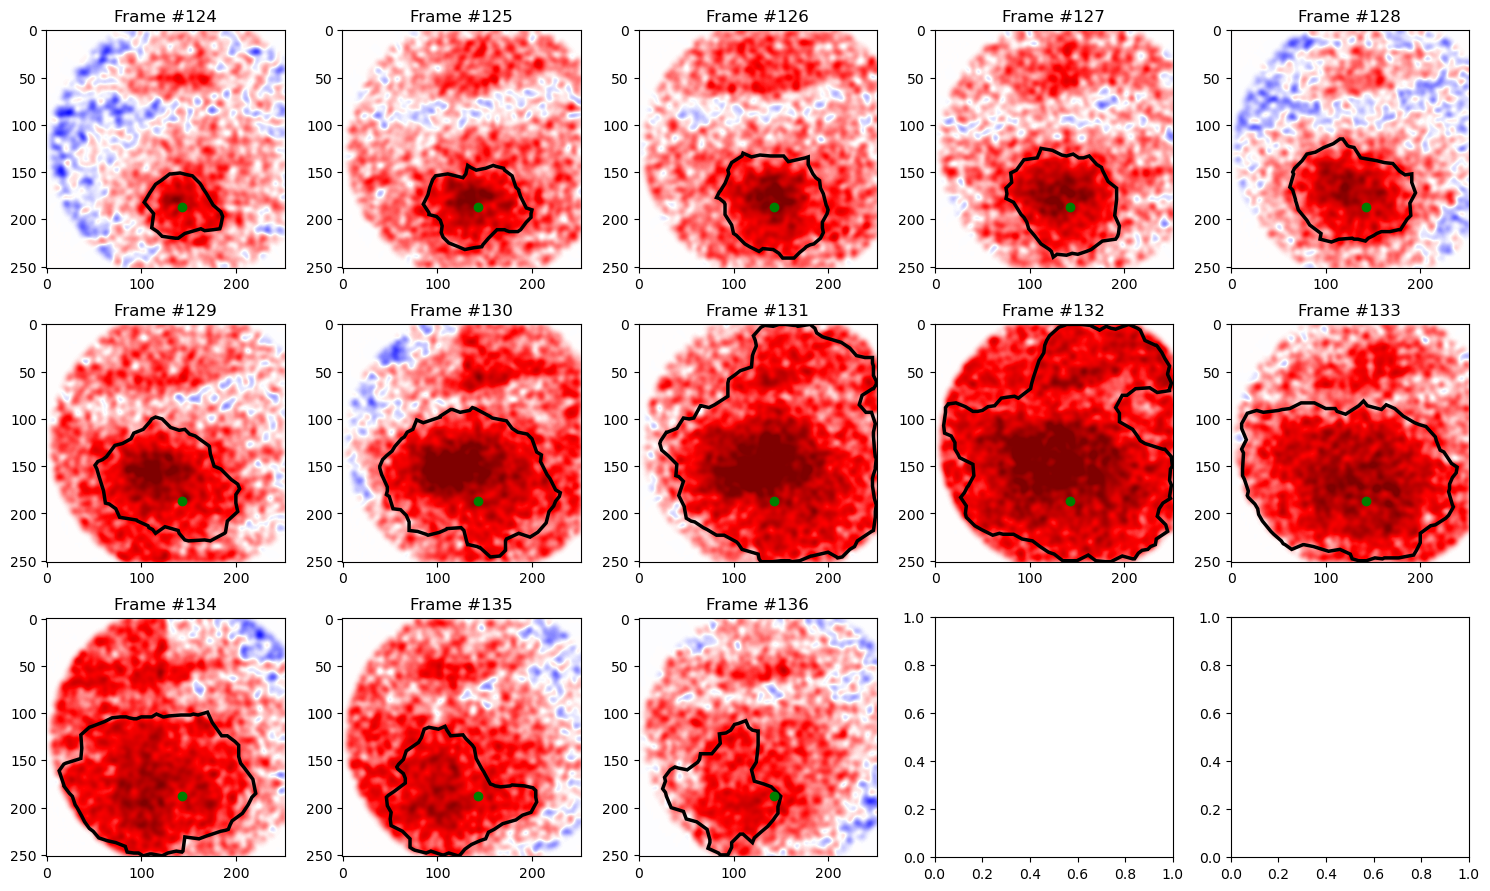

In [172]:
fig_th, axs = plt.subplots(nrow,ncol, figsize=(ncol*3,nrow*3), tight_layout=True)
for index,frame_number in enumerate(moving_clusters[mc_ind]['trace']):
    axs[index//ncol, index%ncol].set_title(f'Frame #{frame_number}')
    axs[index//ncol, index%ncol].plot(Source[1],Source[0],'go')
    axs[index//ncol, index%ncol].imshow(img.gaussian_filter(test_trial[frame_number]*mask, sigma=3, mode='constant'), cmap='seismic', norm=Norm)
    x, y = moving_clusters[mc_ind]['alpha shapes'][index].exterior.xy
    mpl_poly = patch.Polygon(list(zip(y,x)), closed=True, edgecolor='k', facecolor='none', linewidth=2.5)
    axs[index//ncol, index%ncol].add_patch(mpl_poly)

In [173]:
pts_angle_from_source=[]
for clust in pts:
    clust_from_source=clust-Source
    angle=np.arctan2(-clust_from_source[:,0],clust_from_source[:,1])
    pts_angle_from_source.append(angle)
Angles=np.concatenate(pts_angle_from_source)

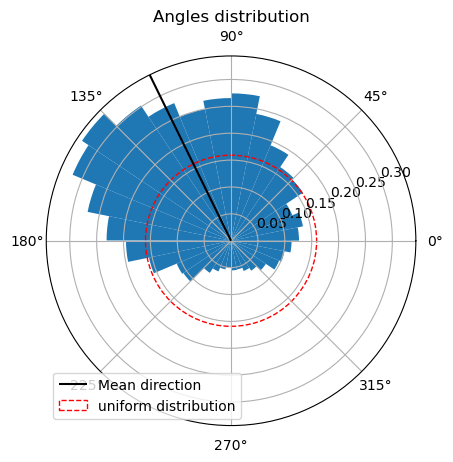

In [174]:
fig, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
ax1.set_title('Angles distribution')
histo = ax1.hist(Angles, bins=32, density=True)
ax1.vlines(stat.circmean(Angles),0,max(histo[0])+.01, colors='k',label='Mean direction')
uniform=patch.Circle((0,0),1/(2*np.pi), color='r',linestyle='dashed',fill=False, label='uniform distribution',transform=ax1.transData._b)
ax1.add_patch(uniform)
ax1.set_ylim(0, max(histo[0])+.01)
plt.legend()
plt.show()

### Test uniformity of the circular distribution

In [175]:
# Sample data: angles in radians
data = Angles#np.random.uniform(0, 2*np.pi, 100)

# Compute mean resultant length
n = len(data)
R = np.sqrt((np.sum(np.cos(data))**2 + np.sum(np.sin(data))**2) / n**2)

# Compute Rayleigh test statistic
Z = n * R**2

# Critical value for the Rayleigh test (for large n, use approximate critical values)
p_value = np.exp(-Z)

print("Rayleigh Test Statistic:", Z)
print("p-value:", p_value)

if p_value < 0.01:
    print("Reject the null hypothesis: the distribution is not uniform.")
else:
    print("Fail to reject the null hypothesis: the distribution may be uniform.")

Rayleigh Test Statistic: 2216.182846698406
p-value: 0.0
Reject the null hypothesis: the distribution is not uniform.


In [176]:
kuiper_test=kuiper(data=Angles, cdf=partial(stat.uniform.cdf, loc=-np.pi, scale=2*np.pi))
print("Kuiper Test Statistic:", kuiper_test[0])
print("fpp:", kuiper_test[1])

if kuiper_test[1] < 0.01:
    print("Reject the null hypothesis: the distribution is not uniform.")
else:
    print("Fail to reject the null hypothesis: the distribution may be uniform.")

Kuiper Test Statistic: 0.24741821461727476
fpp: 0.0
Reject the null hypothesis: the distribution is not uniform.


## 5: Saving relevant examples

In [178]:
np.save('Complex_wave_example', Data[trial_number])